# Canarium GBS: Phylogenetic inference
### *Federman et al.*

This notebook provides all code necessary to reproduce Phylogenetic analyses for the full data sets performed with raxml and tetrad. 

### Required software

In [1]:
## conda install ipyrad -c ipyrad
## conda install toytree -c eaton-lab
## conda install sra-tools -c bioconda
## conda install entrez-direct -c bioconda
## conda install raxml -c bioconda

### Imports

In [40]:
import toytree
import toyplot.svg
import ipyrad as ip
import ipyrad.analysis as ipa
print "ipyrad v.{}".format(ip.__version__)

ipyrad v.0.7.20


### Connect to cluster

In [3]:
import ipyparallel as ipp
ipyclient = ipp.Client()
ip.cluster_info(ipyclient)

host compute node: [40 cores] on sacra


### Get SRA Run info

In [4]:
sra = ipa.sratools(accession="SRP106882", workdir="./fastq-files")
run_info = sra.fetch_runinfo((1,4,6,29,30))
run_info.head()

Fetching project data...

,Run,spots,spots_with_mates,ScientificName,SampleName
0,SRR5534921,12818693,0,Canarium lamianum,SF327
1,SRR5534922,5675773,0,Canarium longistipulatum,D12950
2,SRR5534923,34404746,0,Canarium ovatum,D14269
3,SRR5534924,3382649,0,Canarium pilicarpum,5573
4,SRR5534925,16632442,0,Canarium obtusifolium,SF228


## Links to analyses

+ [RAxML inference](#Phylogenetic-inference)
+ [Concordance factors](#Concordance-factors)
+ [Species delimitation](#BPP-species-tree-parameter-estimation)
+ [Population structure](#Population-structure)
+ [ABBA-BABA tests](#ABBA-BABA-tests)

## Load assembly objects

In [5]:
## reoload assemblies from their JSON files
Can_min4 = ip.load_json("analysis-ipyrad/Canarium-min4.json")
Can_min10 = ip.load_json("analysis-ipyrad/Canarium-min10.json")
Can_min20 = ip.load_json("analysis-ipyrad/Canarium-min20.json")
Can_min30n = ip.load_json("analysis-ipyrad/Canarium-min30-nout.json")

loading Assembly: Canarium-min4
from saved path: ~/Documents/Canarium/analysis-ipyrad/Canarium-min4.json
loading Assembly: Canarium-min10
from saved path: ~/Documents/Canarium/analysis-ipyrad/Canarium-min10.json
loading Assembly: Canarium-min20
from saved path: ~/Documents/Canarium/analysis-ipyrad/Canarium-min20.json
loading Assembly: Canarium-min30-nout
from saved path: ~/Documents/Canarium/analysis-ipyrad/Canarium-min30-nout.json


## RAxML analysis

In [56]:
for dset in [Can_min20, Can_min10, Can_min4]:
    ## init raxml job object
    rax = ipa.raxml(
        name=dset.name, 
        data=dset.outfiles.phy, 
        T=40, 
        N=100,
        o=["D14269", "D13374", "SFC1988", "D13852"],
        )
    ## run raxml job
    rax.run()

job Canarium-min20 finished successfully
job Canarium-min10 finished successfully
job Canarium-min4 finished successfully


## Tetrad analysis

In [35]:
## init tetrad job object
tet = ipa.tetrad(
    name=Can_min4.name, 
    data=Can_min4.outfiles.snpsphy, 
    mapfile=Can_min4.outfiles.snpsmap,
    nboots=100,
    )

## run tetrad job
tet.run(ipyclient=ipyclient, force=True)

loading seq array [42 taxa x 593832 bp]
max unlinked SNPs per quartet (nloci): 137189
inferring 111930 quartet tree sets
host compute node: [40 cores] on sacra
[####################] 100% generating q-sets | 0:00:03 |  
[####################] 100% initial tree      | 0:00:48 |  
[####################] 100% bootstrap trees   | 1:08:03 |  
[####################] 100% calculating stats | 0:00:04 |  


## Plot phylogenies

In [33]:
def get_sra_names(tre, run_info):
    """
    returns tip names in the ladderized order of the tree, and with accession
    numbers replaced by their taxon names in the SRA run table. 
    """
    ## make a new list of names that is the format: [taxon]-[sample ID]
    idxs = [run_info.SampleName.tolist().index(i) for i in tre.get_tip_labels()]
    nns = ["<i>{}</i>-{}".format(run_info.ScientificName[i][:12], run_info.SampleName[i]) for i in idxs]

    ## abbreviate genus name in labels
    nns = [i.replace("Canarium", "C. ") for i in nns]
    return nns

In [34]:
## the outgroup samples
outgroups = ["D14269", "D13374", "D13852", "SFC1988"]

## load raxml trees
raxtre4 = toytree.tree("./analysis-raxml/RAxML_bipartitions.Canarium-min4")
raxtre10 = toytree.tree("./analysis-raxml/RAxML_bipartitions.Canarium-min10")
raxtre20 = toytree.tree("./analysis-raxml/RAxML_bipartitions.Canarium-min20")

## load and root tetrad tree
tettre4 = toytree.tree("./analysis-tetrad/Canarium-min4.nhx")
tettre4 = tettre4.root(outgroups)

### Raxml min20 tree

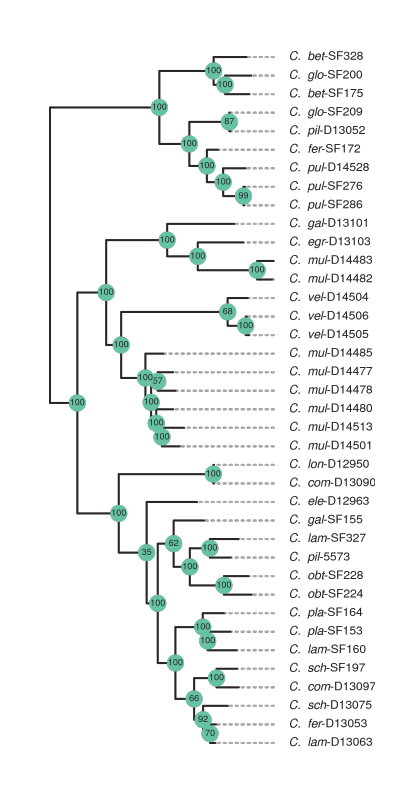

In [44]:
## drop outgroups from the tree
rax = raxtre20.drop_tips(outgroups)

## plot trees with bootstrap supports
canvas, axes = rax.draw(
    width=400, 
    height=800, 
    tip_labels_align=True,
    tip_labels=get_sra_names(rax, run_info),
    node_labels=rax.get_node_values("support"),
    node_size=17,
);

toyplot.svg.render(canvas, "figures/rax20.svg")
canvas

### RAxML min10 tree

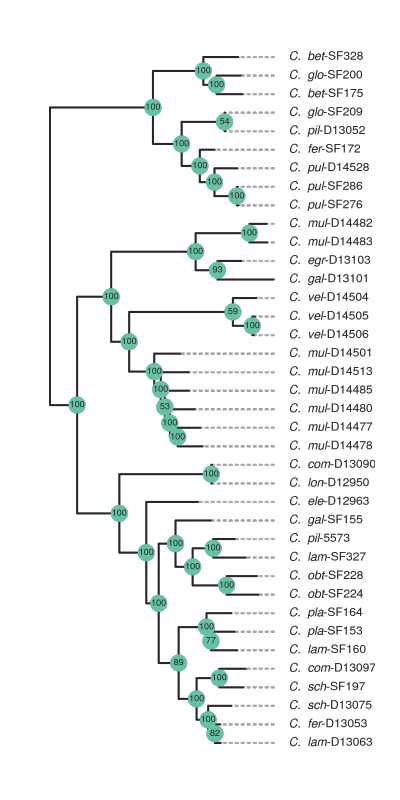

In [47]:
## drop outgroups from the tree
rax = raxtre10.drop_tips(outgroups)

## plot trees with bootstrap supports
canvas, axes = rax.draw(
    width=400, 
    height=800, 
    tip_labels_align=True,
    tip_labels=get_sra_names(rax, run_info),
    node_labels=rax.get_node_values("support"),
    node_size=17,
);

toyplot.svg.render(canvas, "figures/rax10.svg")
canvas

### RAxML min4 tree

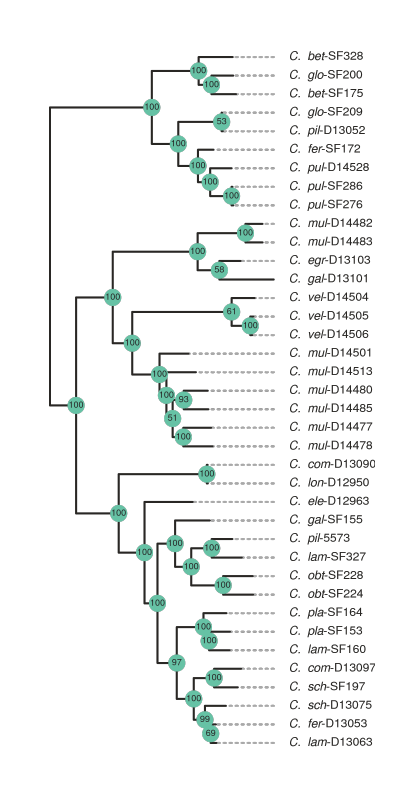

In [48]:
## drop outgroups from the tree
rax = raxtre4.drop_tips(outgroups)

## plot trees with bootstrap supports
canvas, axes = rax.draw(
    width=400, 
    height=800, 
    tip_labels_align=True,
    tip_labels=get_sra_names(rax, run_info),
    node_labels=rax.get_node_values("support"),
    node_size=17,
);

toyplot.svg.render(canvas, "figures/rax4.svg")
canvas

### RAxML min20 tree with outgroups

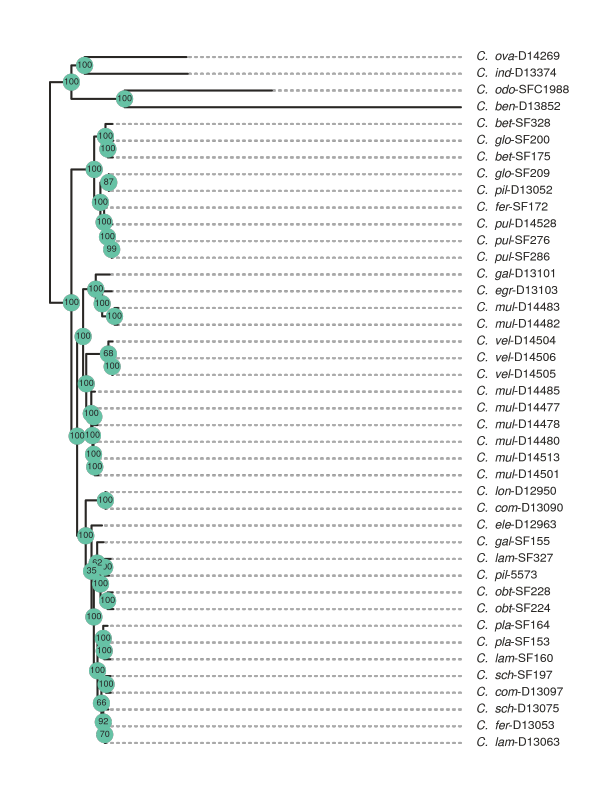

In [50]:
## drop outgroups from the tree
rax = raxtre20

## plot trees with bootstrap supports
canvas, axes = rax.draw(
    width=600, 
    height=800, 
    tip_labels_align=True,
    tip_labels=get_sra_names(rax, run_info),
    node_labels=rax.get_node_values("support"),
    node_size=17,
);

toyplot.svg.render(canvas, "figures/rax20_outg.svg")
canvas

### Tetrad min4 tree

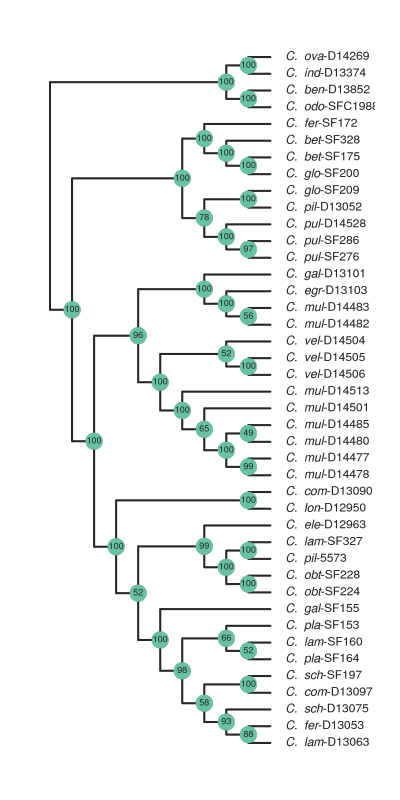

In [52]:
## plot trees with bootstrap supports
canvas, axes = tettre4.draw(
    width=400, 
    height=800, 
    tip_labels=get_sra_names(tettre4, run_info),
    use_edge_lengths=False,
    node_labels=tettre4.get_node_values("support"),
    node_size=17,
);

## save figure
toyplot.svg.render(canvas, "figures/tet4.svg")
canvas

### Test with excluded samples

In [ ]:
data = ip.load_json("analysis_ipyrad/Canarium.json")
erax = ipa.raxml(
    name="with-excluded-samples",
    data=data.outfiles.phy, 
    T=20,
    o=["D14269", "D13374", "SFC1988", "D13852"],
)
erax.run()

In [ ]:
## drop outgroups from the tree
tre = toytree.tree(erax.tree.bipartitions)
tre = tre.drop_tips(["D14269", "D13374", "SFC1988", "D13852"])

## plot trees with bootstrap supports
canvas, axes = tre.draw(
    width=400, 
    height=800, 
    tip_labels_align=True,
    tip_labels=get_sra_names(tre, run_info),
    node_labels=tre.get_node_values("support"),
    node_size=17,
);